In [14]:
# coding=utf-8
import json
import re
import urllib.request
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import os
import sqlite3

import platform
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() =='Windows':
    path="c:/Windows/fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.. sorry')

In [15]:
client_id = "5GMyBAkCtJK7apyvTNoN"
client_secret = "5KoYygDBTg"

In [16]:
def get_request_url(url): # url 받아서 연결
    #print(">###get_request_url()###")
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_secret)
    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None

In [17]:
def getNaverSearchResult(sNode, search_text, page_start, display): # url 합치고 연결하도록 get_request_url 호출
    #print(">###getNaverSearchResult()###")
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % sNode
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(search_text), page_start, display)
    url = base + node + parameters

    retData = get_request_url(url)    
    if (retData == None):
        print("<getNaverSearchResult, retData> 없음, none 리턴")
        return None
    else:
        # print("<getNaverSearchResult, retData > 있음, retData 리턴 ")
        return json.loads(retData)

In [18]:
def getPostData(post, data_list): # json 형식으로 받은 데이터 리스트로 누적해서 저장
    #print(">###getPostData()###")
    title = post['title']
    description = post['description']
    org_link = post['originallink']
    link = post['link']

    pDate = datetime.datetime.strptime(post['pubDate'], '%a, %d %b %Y %H:%M:%S +0900')     # Tue, 14 Feb 2017 18:46:00 +0900
    pDate = pDate.strftime('%Y-%m-%d %H:%M:%S')
    
    list_temp = [title, description, org_link, link, pDate]
    data_list.append(list_temp)
    return

In [19]:
def save_sqlite(db_filename, data_list):
    #db 연결
    db = sqlite3.connect(db_filename + ".db")
    cur = db.cursor()
    
    db_is_new = not os.path.exists(db_filename)
    conn = sqlite3.connect(db_filename)

    if db_is_new:
        print(db_filename, "db 생성")
    else:
        print('이미 db 생성')

    # 테이블 생성
    cur.execute("Drop table if exists %s" % (keyword))
    cur.execute("create table %s (title text, description text, org_link text, link text, date text)" % (keyword))
    print("%s table 생성" % (keyword))
    
    # 테이블에 삽입
    sql = 'insert into %s values (?, ?, ?, ?, ?)' % (keyword)
    cur.executemany(sql, data_list)
    db.commit()
    print("%s table 삽입 완료" % (keyword))
    
    # dataframe으로 저장
    cur.execute('select * from %s' %(keyword))
    info_temp = cur.fetchall()
    df = pd.DataFrame(info_temp,columns=['title','description','org_link','link', 'date'])
    
    db.close()
    return df
 

In [20]:
def main(keyword):
    print(">###main()###")
    # parmas
    sNode = 'news'
    search_text = keyword
    nStart = 1
    display_count = 100

    # empty list
    data_list = []

    while( (nStart< 1000)):
        # bring data with url
        print("nStart= ", nStart)
        jsonSearch = getNaverSearchResult(sNode, search_text, nStart, display_count)
        if jsonSearch == None:
            print("검색이 되지 않습니다. ")
            break
        elif jsonSearch['display'] == 0:
            print("더 이상 검색이 되지 않습니다. display value is 0 ")
            break
        # parse data with loop
        for post in jsonSearch['items']: 
            # save json result in a data_list
            getPostData(post, data_list)

        # make new nstart int value for loop: 1 + 100, 101 + 100
        nStart = jsonSearch['start'] + jsonSearch['display'] 
    print("검색이 완료 되었습니다.\n")
    return data_list

In [21]:
if __name__ == '__main__':
    keyword = '"' + input("검색할 키워드 입력 => ") + '"'
    db_filename = "news_crawling"

    data_list = main(keyword)
    df = save_sqlite(db_filename, data_list)
    
    df.to_csv("news_crawling.csv", encoding='utf-8', index=False)
    print("end")


검색할 키워드 입력 => 오티스 엘리베이터
>###main()###
nStart=  1
[2018-10-01 18:57:57.170491] Url Request Success
nStart=  101
[2018-10-01 18:57:57.383208] Url Request Success
nStart=  201
[2018-10-01 18:57:57.504882] Url Request Success
nStart=  301
[2018-10-01 18:57:57.696743] Url Request Success
nStart=  401
[2018-10-01 18:57:57.790450] Url Request Success
nStart=  501
[2018-10-01 18:57:57.973882] Url Request Success
nStart=  601
[2018-10-01 18:57:58.191350] Url Request Success
nStart=  701
[2018-10-01 18:57:58.297329] Url Request Success
nStart=  801
[2018-10-01 18:57:58.494931] Url Request Success
nStart=  901
[2018-10-01 18:57:58.705621] Url Request Success
검색이 완료 되었습니다.

이미 db 생성
"오티스 엘리베이터" table 생성
"오티스 엘리베이터" table 삽입 완료
end


In [30]:
temp_df = pd.read_csv('news_crawling.csv')
df = temp_df.iloc[:,[0,1,4]]
df.sort_values(by="date", ascending=False).head()

print(df.title.nunique())
print(len(df))

929
1000


In [50]:
import nltk
from konlpy.corpus import kolaw
from konlpy.tag import Hannanum; Hannanum = Hannanum()
from konlpy.tag import Kkma; Kkma = Kkma()
from konlpy.tag import Komoran
from konlpy.tag import Mecab
from konlpy.tag import Twitter; t = Twitter()

c:\bigdeep\python36\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


# 제목/ 전체로 나눠서 시각화하기

In [51]:
# 제목만 먼저 보기
temp_df_title = ""
for i in temp_df["title"]:
    temp_df_title += " " + i
    
temp_df_title_ko = Hannanum.nouns(temp_df_title)

In [78]:
# 토큰 알아보기

ko = nltk.Text(temp_df_title_ko)

print(len(ko.tokens))       # returns number of tokens (document length)
print(len(set(ko.tokens)))  # returns number of unique tokens
ko.vocab()                  # returns frequency distribution

5611
2184


FreqDist({'엘리베이터': 139, '>,': 105, '<b>오티스': 97, '현대엘리베이터': 82, '승강기': 80, '오티스,': 79, '사장': 79, '장병우': 71, '>': 64, '오티스': 62, ...})

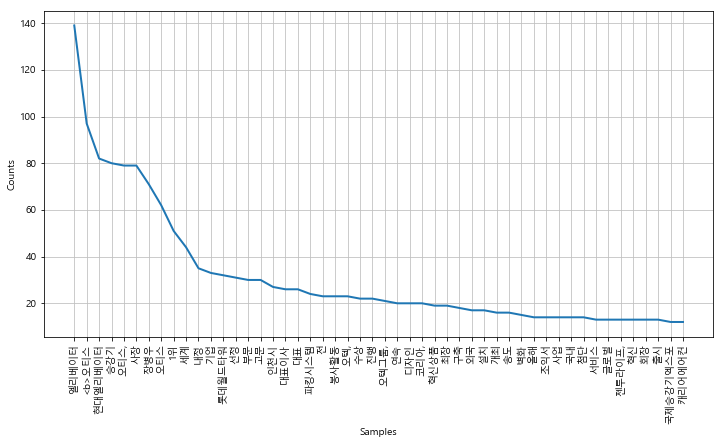

In [64]:
# 그래프로 보기

stop_words = ['.', '(', ')', ',', "'",'%','_', 'X', ').', 'x', '의', '자', '에', '안','번','호', '을', '이','다', '만','로','가','를', \
             '>,', '<b>', '>', '취', '수', '신']
ko = [each_word for each_word in ko if each_word not in stop_words]

ko2 = nltk.Text(ko)
plt.figure(figsize=(12,6))
ko2.plot(50)
plt.show()

In [80]:
ko2 = nltk.Text(ko)
ko2.vocab().most_common(20)

[('엘리베이터', 139),
 ('>,', 105),
 ('<b>오티스', 97),
 ('현대엘리베이터', 82),
 ('승강기', 80),
 ('오티스,', 79),
 ('사장', 79),
 ('장병우', 71),
 ('>', 64),
 ('오티스', 62),
 ('1위', 51),
 ('신', 49),
 ('세계', 44),
 ('내정', 35),
 ('기업', 33),
 ('롯데월드타워', 32),
 ('선정', 31),
 ('부문', 30),
 ('고문', 30),
 ('인천시', 27)]

경쟁사인 현대 엘리베이터가 보이고,  
최근 사장님이 바귀었는지 사장/장병우 이런 명사들이 많이 나온다. 아마 "세계", "1위"와 같은 이야기를 취임사에 많이 넣으 셨나보다.  

롯데우러드타워는 오티스가 한 대표적인 고층 건물이고,   
음 그거 말고는 크게 두드러진 것이 없다.

그래서 3가지 기능으로 더 알아보려 한다.
> collocations  
 concordance  
 similar  

In [81]:
# 같이 나온 글자
ko2.collocations()

현대엘리베이터 장병우; 오티스 젠투라이프,; '광진 블리스힐'; 유지관리 10만대; 스카이라이즈 제품군; ‘그린슈츠 캠페인’;
2017 이노스타'; 엘리베이터 스카이라이즈; 디자인 어워드; 김기영 송산특수엘리베이터; 목적층 선행등록; 자동차 파킹시스템;
‘시그니처 서비스’; 안상수 창원시장; 승강기 유지관리; 선행등록 시스템; 초고층 엘리베이터; GeN2, ‘2015; 디자인
어워드'; 오티스 젠투다이나믹,


음.. 같이 묶인것도 특별한게 없다.    
장병우 대표이사님이 취임하셨나보다.    
  
젠투라이프가 밀고 있는 기종이고    
유지관리 10만대를 강조하고 싶었나보다   

그린슈츠와 캠페인이 많이 나왔다.

In [82]:
ko2.concordance('그린슈츠')

Displaying 5 of 5 matches:
리 대비 [잡식]언젠간 쓸모 지 지식 18 <b>오티스 > 코리아, 그린슈츠 캠페인 진행 오티스, 지역 아동센터 엘리베이터 전 교육 <b>오티스
오티스, 지역 아동센터 엘리베이터 전 교육 <b>오티스 > 코리아, 그린슈츠 캠페인 진행 <b>오티스 >, ‘그린슈츠 캠페인’ 진행 <b>오티스
들 엘리베이터 교육 &quot;엘리베이터 안전하게&quot; 오티스 그린슈츠 캠페인 <b>오티스 >, ‘그린슈츠 캠페인’ 실시 >, 어린이 안전
교육 ‘그린슈츠’ 진행 오티스 코리아, 안전한 엘리베이터 이용 교육 그린슈츠 프로그램 런칭 오티스코리아, '그린슈츠 프로그램 런칭… 확대 세계 
 안전한 승강기 이용 사회공헌활동 런칭 오티스 안전 승강기 이용교육 그린슈츠 진행 오티스 코리아, 안전한 엘리베이터 이용 교육…그린슈츠 프로그램


봉사활동의 보도자료다

In [83]:
ko2.concordance('김기영')

Displaying 7 of 7 matches:
용 오티스 전세계 승강기 정보 연결…‘커넥티드 디지털 생태계’ 구축 김기영 송산특수엘리베이터 대표 &quot;승강기산업 주권 찾는다&quot;
단 하이테크 산업 세계 유일 승강기 대학 세계 1등 기술 수출 가속 김기영 송산특수엘리베이터 대표 | [올부 이야기⑨] 30년 엘리베이터맨, 
티스 젠투다이나믹, 플랫벨트 적용 시 위험 [박순욱 기업 탐방 34 김기영 송산특수엘리베이터 대표 | 300명 탑승 헬스케어타운 제2 제주공항
송산특수엘리베이터] 세계최초 500명 탑승 엘리베이터 개발 [핌톡] 김기영 한국엘리베이터 협회장 한탄 전세계 기술‘골리앗 엘리베이터’ 승부 김
영 한국엘리베이터 협회장 한탄 전세계 기술‘골리앗 엘리베이터’ 승부 김기영 송산특수엘리베이 김기영 한국엘리베이터협회장, “중국산 점령한 엘리베
 한탄 전세계 기술‘골리앗 엘리베이터’ 승부 김기영 송산특수엘리베이 김기영 한국엘리베이터협회장, “중국산 점령한 엘리베이터 시장 기술력 &qu
행 불참 >, 승강기 유지보수시장 1위 [CEO&amp;Story] 김기영 송산특수엘리베이터 대표 창원국가산업단지 투자 불황타개 2015 춘계


김기영이라는 분이 오티스 출신으로 송산특수엘리베이터에서 높으신 분인가보다. 

In [84]:
ko2.similar('장병우')

신 사장 적극 대표 선 내정 케네스


장병우 대표님이 사장으로 내정되셨고, 적극적으로 세계화 시대에 노력하겠다는 이야기를 많이 하셨나보다.  

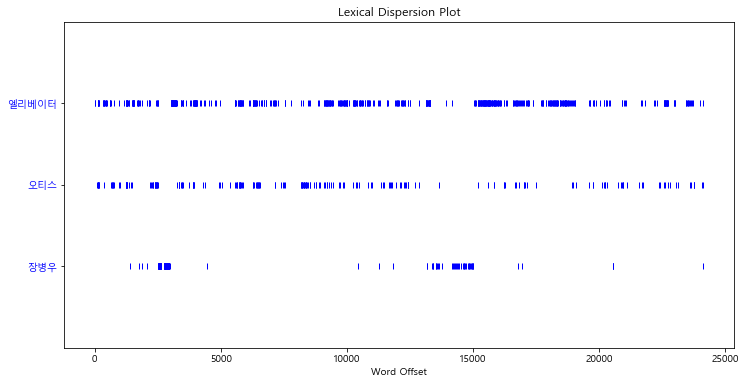

In [99]:
plt.figure(figsize=(12,6))
ko2.dispersion_plot(['엘리베이터', '오티스', '장병우'])

총 5000개 정도의 글자가 추출되었는데 엘리베이터라는 키워드가 많다.  
이제 워드 클라우드로 함 만들어보려한다.
좀 더 다듬어야 하는데 일단 이렇게 할란다. 

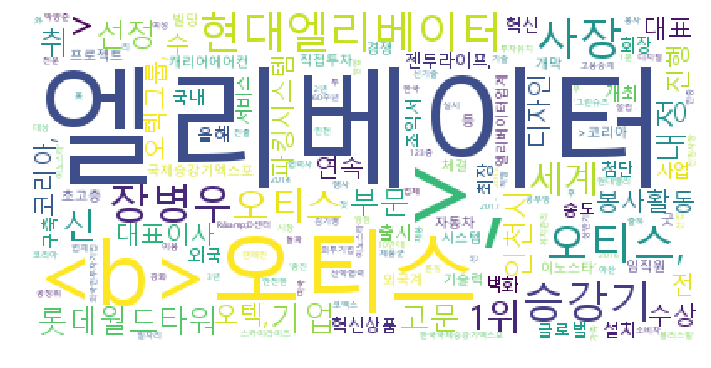

In [89]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

data = ko2.vocab().most_common(150)

wordcloud = WordCloud(font_path='/Library/Fonts/malgun.ttf',
                    relative_scaling = 0.2,
                    background_color='white',
        ).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 제목 말고 내용까지 고려해보려한다.  
- 단 기사의 전문을 가져온 것이 아니라, 첫 문단만 가져왔다.  네이버 API 사용해서  

In [91]:
# 데이터 합치고
temp_df_total = ""
for i in temp_df["title"]:
    temp_df_total += " " + i

for i in temp_df["description"]:
    temp_df_total += " " + i    
    
temp_df_total_ko = Hannanum.nouns(temp_df_total)
temp_df_total_ko[:5]

['현대', '상반기', '엘리베이터', '시공', '넘버']

In [92]:
ko = nltk.Text(temp_df_total_ko)

print(len(ko.tokens))
print(len(set(ko.tokens)))
ko.vocab()


25362
5741


FreqDist({'>': 836, '<b>오티스': 545, '엘리베이터': 528, '등': 352, '사장': 330, '현대엘리베이터': 254, '승강기': 229, '코리아': 212, '오티스': 200, '>,': 198, ...})

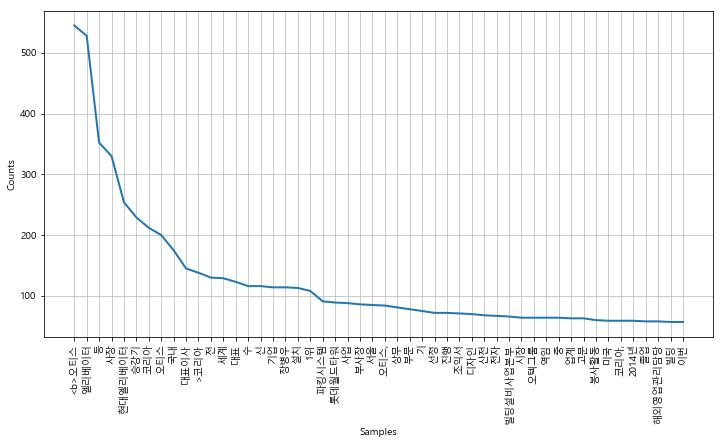

In [98]:
stop_words = ['.', '(', ')', ',', "'",'%','_', 'X', ').', 'x', '의', '자', '에', '안','번','호', '을', '이','다', '만','로','가','를', \
             '>,', '<b>', '>', '취']
ko = [each_word for each_word in ko if each_word not in stop_words]

ko2 = nltk.Text(ko)
plt.figure(figsize=(12,6))
ko2.plot(50)
plt.show()

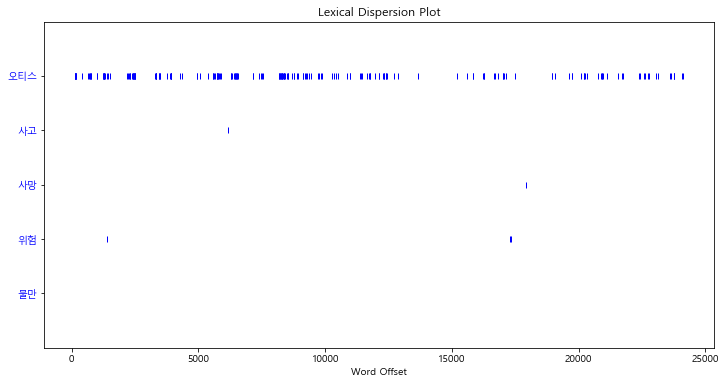

In [100]:
plt.figure(figsize=(12,6))
ko2.dispersion_plot(['오티스', '사고', '사망', '위험', '불만'])

사고, 사망, 위험, 불만 같은 키워드는 간혹 있는 것 같다.
저것이 무엇인지는 DB 들어가서 보면 될듯

In [112]:
temp_df[temp_df['description'].str.contains("사고")].head()

,title,description,org_link,link,date
43,벤처·과학기술계 &quot;데이터 개방&quot; 촉구,주제 발표를 맡은 이민화 벤처기업협회 명예 회장은 &quot;<b>오티스 엘리베이터...,http://www.newstomato.com/ReadNews.aspx?no=803802,http://www.newstomato.com/ReadNews.aspx?no=803802,2018-01-31 17:32:00
213,홍콩서 4층 높이 에스컬레이터 역주행해 18명 부상…2명 체포,경찰은 엘리베이터 제조업체 <b>오티스 엘리베이터</b> 컴퍼니의 직원 2명을 체포...,http://app.yonhapnews.co.kr/YNA/Basic/SNS/r.as...,https://news.naver.com/main/read.nhn?mode=LSD&...,2017-03-28 00:14:00
281,&quot;1초에 21미터&quot;…초고속에 멀티 엘리베이터까지,▶ 인터뷰 : 이은영 / <b>오티스엘리베이터</b> 부장 - &quot;지진이 발...,http://www.mbn.co.kr/pages/vod/programView.mbn...,https://news.naver.com/main/read.nhn?mode=LSD&...,2016-11-17 20:09:00
284,&quot;1초에 21미터&quot;…초고속에 멀티 엘리베이터까지,▶ 인터뷰 : 이은영 / <b>오티스엘리베이터</b> 부장 - &quot;지진이 발...,http://mbn.mk.co.kr/pages/news/newsView.php?ca...,https://news.naver.com/main/read.nhn?mode=LSD&...,2016-11-17 19:43:00
348,승강기 보수 최저가입찰제 폐지…현대엘리베이터에 호재,그동안 현대엘리베이터와 <b>오티스엘리베이터</b> 등 승강기업계에서는 유지관리 최...,http://news1.kr/articles/?2750529,https://news.naver.com/main/read.nhn?mode=LSD&...,2016-08-19 06:00:00


2018년에 나온 '사고'는 사고를 예방한다의 사고 였다.

In [113]:
temp_df[temp_df['description'].str.contains("사망")].head()

,title,description,org_link,link,date
664,[광화문 광장-브래들리 벅월터]안전에 투자하라,"한국에 와서 얼마 되지 않았을 때, 당시 <b>오티스엘리베이터</b>에서 근무하고 ...",http://biz.heraldcorp.com/view.php?ud=20150519...,https://news.naver.com/main/read.nhn?mode=LSD&...,2015-05-19 11:03:00


이거는 새로 취임한 사장님이 예전에 한국 사망사고 급하게 하느라 있었다고 자기는 안 그럴 거라고 하는 내용이다.

In [115]:
temp_df[temp_df['description'].str.contains("위험")].head()

,title,description,org_link,link,date
631,칠곡군 승강기 승객구조훈련 실시,"이번 훈련은 군이 주관하고 칠곡소방서, 승강기 안전관리원, <b>오티스 엘리베이터<...",http://www.hidomin.com/news/articleView.html?i...,http://www.hidomin.com/news/articleView.html?i...,2015-10-22 01:01:00
633,"달성군, '2015 승강기 갇힘사고 승객구조훈련' 실시","달성군이 주관하고 달성군 시설관리공단, 달성소방서, 승강기 안전관리원, <b>오티스...",http://www.anewsa.com/detail.php?number=905976...,http://www.anewsa.com/detail.php?number=905976...,2015-10-18 09:51:00
829,기업의 미래전략 중점 평가…2013글로벌 스탠더드 경영대상,안전경영대상에는 <b>오티스 엘리베이터</b> 코리아가 국내 최초 24시간 엘리베이...,http://www.econovill.com/archives/130018,http://www.econovill.com/archives/130018,2013-10-28 11:50:00


오티스가 협조한 안전 행사들이다. 
딱히 안좋은 내용은 없다.

In [117]:
ko2.collocations()

<b>오티스 코리아; 빌딩설비사업본부 부사장; 서울대 영어영문학과; 부사장 대표이사; 코리아(사장 조익서); 파킹시스템
사업부문; 롯데월드타워 최상부; 한국지멘스, 한국후지제록스,; 코리아(이하 오티스); 전망대용 엘리베이터; 구성도 설치사례;
<b>오티스 코리아(이하; 문도열(전 우석대; 임직원 가족들; 목적층 선행등록; 스탠퍼드대 케임브리지대; >코리아,
한국지멘스,; <b>오티스 코리아(사장; 외국인투자기업 주한외국상; 연구소 한국분원


묶여있는 것을 표시하는 colllocations()는 특별한게 없다.

In [119]:
ko2.concordance('그린슈츠')

Displaying 17 of 17 matches:
격관리 대비 [잡식]언젠간 쓸모 지 지식 18 <b>오티스 코리아, 그린슈츠 캠페인 진행 오티스, 지역 아동센터 엘리베이터 전 교육 <b>오티스
행 오티스, 지역 아동센터 엘리베이터 전 교육 <b>오티스 코리아, 그린슈츠 캠페인 진행 <b>오티스 ‘그린슈츠 캠페인’ 진행 <b>오티스 어린
들 엘리베이터 교육 &quot;엘리베이터 안전하게&quot; 오티스 그린슈츠 캠페인 <b>오티스 ‘그린슈츠 캠페인’ 실시 어린이 안전교육 캠페인
교육 ‘그린슈츠’ 진행 오티스 코리아, 안전한 엘리베이터 이용 교육 그린슈츠 프로그램 런칭 오티스코리아, '그린슈츠 프로그램 런칭… 확대 세계 
 안전한 승강기 이용 사회공헌활동 런칭 오티스 안전 승강기 이용교육 그린슈츠 진행 오티스 코리아, 안전한 엘리베이터 이용 교육…그린슈츠 프로그램
하 오티스) 경기 시흥시 지역아동센터 방문 ‘그린슈츠 캠페인’ 진행 그린슈츠 캠페인 학습공간 생활환경 개선 승강기 전 교육 진행 사회공헌 시흥서
경기 양 금빛지역 아동센터 '그린슈츠(Green 캠페인 진행 22일 그린슈츠 캠페인 안전한 엘리베이터 이용 교육 환경 개 양 금빛아동센터 시설개
 금빛지역 아동센터 ‘그린슈츠(Green Shoots)’캠페인 진행 그린슈츠 캠페인 안전한 엘리베이터 이용 교육 환경 개 작업 구성 사회공헌 경
 센터 도배 책걸상 교체 작업 참여 >코리아 임직원 아동들 기념사진 그린슈츠 캠페인 오티스코리아 모회사 2011년 전 세계적 진행 사회공헌활동 
코리아 서울 신길동 대영초등학교 어린이들 대상 안전 승강기 이용교육 그린슈츠 프로그램 진행 30일 학생들 엘리베이터 모형 <b>오티스 코리아 초
 <b>오티스 코리아 초등학교 어린이들 안전 승강기 이용 교육 사용 그린슈츠 프로그램 런칭했다 프로그램 사회공헌 활동 일종 2011년 <b>오티
서울 신길동 소재 서울대영초등학교 어린이들 안전한 승강기 이용 교육 그린슈츠 프로그램 런칭했다 어린이 눈높이 교육 등 다채로운 행사 오티스코리 

이건 그린슈츠 보도자료가 비슷한게 많은가 궁금하다

In [132]:
temp_df[temp_df['description'].str.contains("그린")].head()

,title,description,org_link,link,date
107,[포토] <b>오티스엘리베이터</b> `행복 벽화`,<b>오티스엘리베이터</b>코리아의 사내 모임인 '우먼스 카운슬' 회원과 가족 등 ...,http://news.mk.co.kr/newsRead.php?year=2017&no...,https://news.naver.com/main/read.nhn?mode=LSD&...,2017-10-16 17:34:00
181,"오티스, 환경개선 ‘그린슈츠 캠페인’ 진행",5월 30일 경기도 시흥시 자연과 아이들 지역아동센터에서 ‘그린슈츠 캠페인’ 에 참...,http://www.electimes.com/article.php?aid=14963...,http://www.electimes.com/article.php?aid=14963...,2017-06-01 17:00:00
183,"<b>오티스엘리베이터</b>, 시흥 아동센터서 환경 개선활동과 승강기 안전교육 진행",<b>오티스엘리베이터</b>코리아는 지난 30일 경기도 시흥 지역아동센터를 방문해 ...,http://biz.chosun.com/site/data/html_dir/2017/...,https://news.naver.com/main/read.nhn?mode=LSD&...,2017-05-31 16:50:00
184,"오티스, 시흥 아동센터 공부방 환경개선",<b>오티스엘리베이터</b>코리아가 경기 시흥 지역아동센터를 방문해 학습공간을 개선...,http://news.mk.co.kr/newsRead.php?&year=2017&n...,https://news.naver.com/main/read.nhn?mode=LSD&...,2017-05-31 16:15:00
185,"오티스, 시흥 아동센터 공부방 환경개선",<b>오티스엘리베이터</b>코리아가 경기 시흥 지역아동센터를 방문해 학습공간을 개선...,http://news.mk.co.kr/newsRead.php?&year=2017&n...,https://news.naver.com/main/read.nhn?mode=LSD&...,2017-05-31 15:01:00


그린 슈츠 관련 기사다. 아마 API 가져올 때 날짜 순으로 가져오지 않아서 그런거 같다.  
제대로 하려면 서버에 새로운 기사들을 저장하고, 실시간으로 내가 만든 서버에서 가져와야하는데
그렇게까지 빡세게 할 필요는 없을 것 같았다

만약 그렇게 할라면 bs4를 쓰면 될 듯하다.

In [136]:
# bs4 예시
import pandas as pd
import numpy as np

import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')    

plt.rcParams['axes.unicode_minus'] = False

from bs4 import BeautifulSoup 
from urllib.request import urlopen
import urllib
import time

In [138]:
from bs4 import BeautifulSoup 
from urllib.request import urlopen, Request
import urllib
html = 'https://search.naver.com/search.naver?query={key_word}&where=news&ie=utf8&sm=nws_hty'
#html = 'http://kin.naver.com/search/list.nhn?query={key_word}&page={num}'

req = Request(html.format(num=1, key_word=urllib.parse.quote('오티스 엘리베이터')));
req.add_header('Referer', 'http://www.naver.com/')

response = urlopen(req)

soup = BeautifulSoup(response, "html.parser")

tmp = soup.find_all('dl')

tmp_list = []
for line in tmp:
    tmp_list.append(line.text)
    
tmp_list

[' 기본검색   입력한 단어가 하나이상 포함된 문서 검색  ',
 ' 상세검색  정확히 일치하는 단어/문장(" ") 반드시 포함하는 단어(+) 제외하는 단어(-)  기본검색의 결과 범위를 줄이고자 할 때 사용합니다.여러개의 단어를 입력하실 때는쉼표(,)로 구분해서 입력하세요.   ',
 ' 연관검색어도움말    오티스   오티스 엘리베이터 연봉   현대엘리베이터   오티스 엘리베이터 파업   엘리베이터   오티스 엘리베이터 채용   미쓰비시엘리베이터   티센크루프 엘리베이터   otis   한국미쓰비시엘리베이터     닫기 후 1주일간 유지됩니다. 연관검색어를 다시 보시겠습니까? 열기 ',
 " 오티스, 향균 기능 특화 ‘젠투 케어’ 엘리베이터 출시 이뉴스투데이  2018.08.13.   보내기   오티스는 엘리베이터, 에스컬레이터, 무빙워크를 포함한 빌딩 내 운송설비 제품 관련 제조 및 유지관리 전문기업으로, 유나이티드 테크놀로지스(UTC)의 자회사다. 젠투 케어 카 내부에는 항균성을 강화해 세균...     오티스, 항균 기능 특화 '젠투 케어' 엘리베이터 출시… 차별화 가치제고 만전  국토일보  2018.08.13.     오티스, 항균 기능 특화된 ‘젠투 케어’ 엘리베이터 출시  전기신문  2018.08.13.     ",
 " 현대, 상반기 엘리베이터 시공 '넘버 원'…누적대수도 1위 전기신문  2018.09.06.   보내기   이어서 외국계 기업인 티센크루프엘리베이터가 5480대로 2위를 차지했고, 오티스엘리베이터가 2483대, 미쓰비시엘리베이터가 796대를 설치하며 뒤를 이었다. 한국쉰들러는 불과 19대, 지난해 국내에 새롭게 진출한... ",
 " 오티스엘리베이터, 새 ‘시그니처 서비스’ 연말 론칭 미디어펜  2018.05.30.   보내기   사진=오티스엘리베이터 제공 오티스의 새로운 시그니처 서비스는 지난 160여년간 축적된 전문 경험을 보유하고 있는 숙련된 직원들과 오티스 문화 및 가치에 대한 그들의 열정과 헌신을 기반으로 한다. 새로운